In [1]:
library(tidyverse)
library(scales)
library(viridis)
library(RColorBrewer)
library(stringr)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: viridisLite


Attaching package: ‘viridis’


The following objec

In [2]:
plots_dir = "SCENICplus_plots/"
dir.create(plots_dir)

Warning message in dir.create(plots_dir):
“'SCENICplus_plots' already exists”


In [3]:
#fetal_disease_TFs <- read.csv("04_fetal_disease_direct_TFs.csv")
fetal_disease_TFs <- read.csv("04_fetal_disease_up_TFs.csv")
fetal_disease_TFs$X <- NULL

# simplify the index to remove the (XXg) information
fetal_disease_TFs$index <- gsub("\\_\\(.*", "", fetal_disease_TFs$index)

# keep only those for which the TF is an activator of some sort
fetal_disease_TFs <- fetal_disease_TFs[grepl("\\+/", fetal_disease_TFs$index), ]

fetal_disease_TFs %>% head()

,index,FC,contrast,cell_type,FC_diff
,<chr>,<dbl>,<chr>,<chr>,<dbl>
3,POU2F2_extended_+/+,2.220017,fetal/ND,Cardiomyocyte,1.220017
5,ZFX_direct_+/-,2.336580,fetal/ND,Cardiomyocyte,1.336580
6,GATAD1_direct_+/-,2.442420,fetal/ND,Cardiomyocyte,1.442420
8,POU2F1_direct_+/-,2.869458,fetal/ND,Cardiomyocyte,1.869458
9,ARID3A_extended_+/-,2.885856,fetal/ND,Cardiomyocyte,1.885856
10,SMAD3_direct_+/+,3.074187,fetal/ND,Cardiomyocyte,2.074187


In [4]:
fetal_disease_TFs %>% group_by(index, contrast) %>% count() %>% head()

index,contrast,n
<chr>,<chr>,<int>
ACAA1_extended_+/+,D/ND,1
ACAA1_extended_+/+,fetal/D,1
ACAA1_extended_+/+,fetal/ND,1
ADNP_direct_+/+,D/ND,1
ADNP_direct_+/+,fetal/D,1
ADNP_direct_+/+,fetal/ND,1


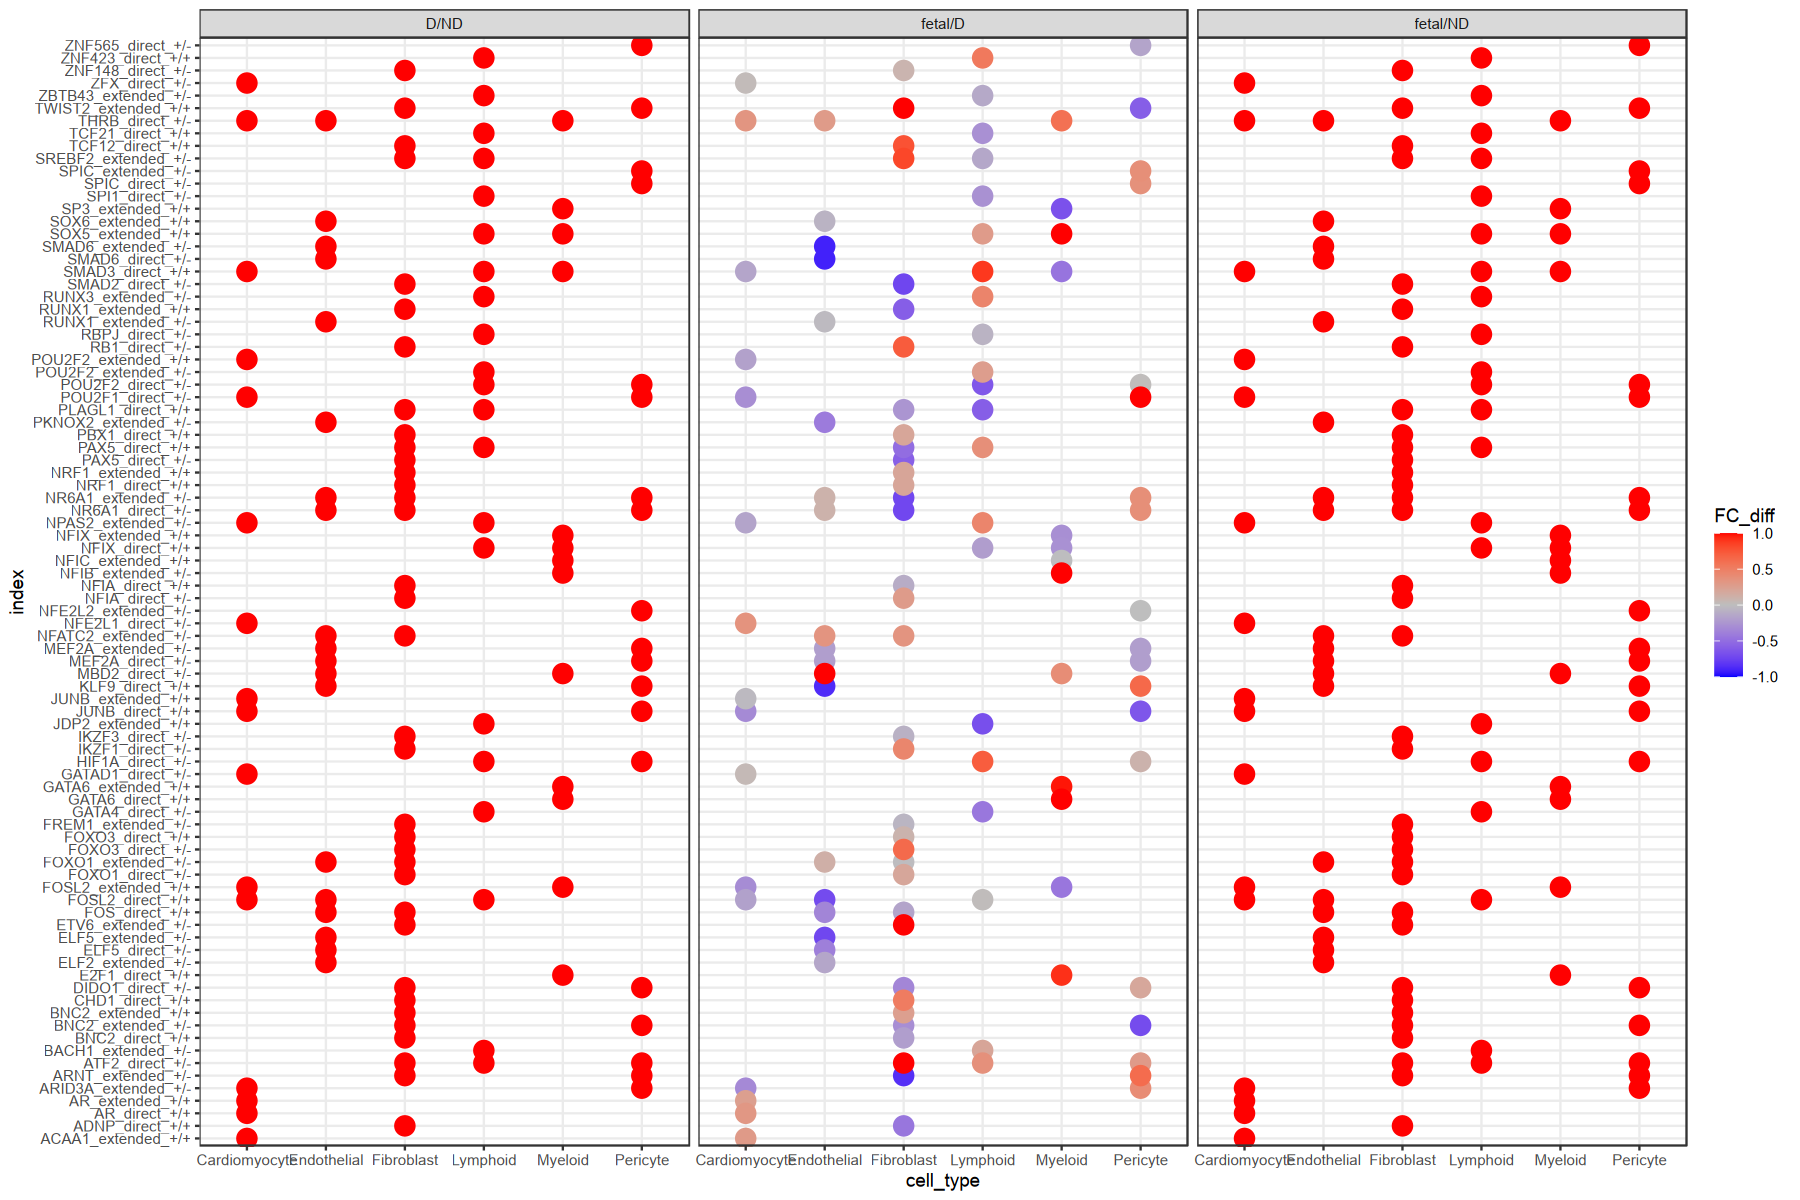

In [5]:
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot(data = fetal_disease_TFs, mapping = aes(x = cell_type, y = index, color = FC_diff)) + 
geom_point(size = 5) + facet_wrap( ~ contrast) + 
scale_color_gradient2(
    low = "blue",    # color for negative values
    mid = "gray",   # midline color
    high = "red",    # color for positive values
    midpoint = 0, # midpoint value
    limits = c(-1, 1), # midpoint value
    oob = scales::squish
  ) +
theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 16),
         axis.text.y = element_text(size = 16)) + theme_bw()

### Create a plot where baseline activity is 1 for ND, and then compute the activity score for the diseased and fetal

In [6]:
length(unique(fetal_disease_TFs$index))

[1] 88

In [7]:
activity_df <- fetal_disease_TFs %>%
  group_by(index, cell_type) %>%
  summarize(
    ND = 1, # Baseline activity
    fetal = ifelse(any(contrast == "fetal/ND"), ND * FC[contrast == "fetal/ND"], NA),
    disease = ifelse(any(contrast == "D/ND"), ND * FC[contrast == "D/ND"], NA)
  ) %>%
  ungroup() %>% 
  mutate(
    # Create direction column based on conditions
    direction = case_when(
      !is.na(fetal) & !is.na(disease) & fetal < 1 & disease < 1 ~ "down",
      !is.na(fetal) & !is.na(disease) & fetal > 1 & disease > 1 ~ "up",
      TRUE ~ NA_character_  # Set to NA if neither condition is met
    )
)

activity_df %>% head()

`summarise()` has grouped output by 'index'. You can override using the `.groups` argument.


index,cell_type,ND,fetal,disease,direction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ACAA1_extended_+/+,Cardiomyocyte,1,4.033474,3.115170,up
ADNP_direct_+/+,Fibroblast,1,9.079113,16.435703,up
ARID3A_extended_+/-,Cardiomyocyte,1,2.885856,4.312655,up
ARID3A_extended_+/-,Pericyte,1,8.909429,6.334988,up
ARNT_extended_+/-,Fibroblast,1,2.091811,13.967742,up
ARNT_extended_+/-,Pericyte,1,5.853598,3.600496,up


In [8]:
activity_pivot_df =  activity_df %>%
  pivot_longer(
    cols = c(ND, fetal, disease), # columns to pivot 
    names_to = "state",           # name of column
    values_to = "activity"        # column of values
  )

In [9]:
activity_pivot_df %>% head()

index,cell_type,direction,state,activity
<chr>,<chr>,<chr>,<chr>,<dbl>
ACAA1_extended_+/+,Cardiomyocyte,up,ND,1.000000
ACAA1_extended_+/+,Cardiomyocyte,up,fetal,4.033474
ACAA1_extended_+/+,Cardiomyocyte,up,disease,3.115170
ADNP_direct_+/+,Fibroblast,up,ND,1.000000
ADNP_direct_+/+,Fibroblast,up,fetal,9.079113
ADNP_direct_+/+,Fibroblast,up,disease,16.435703


In [10]:
activity_pivot_df$TF_and_cell_type <- paste0(activity_pivot_df$index, "_", activity_pivot_df$cell_type)
activity_pivot_df$state <- factor(activity_pivot_df$state, levels = c("fetal", "ND", "disease"))

split_column <- strsplit(activity_pivot_df$TF_and_cell_type, "_")

# extract the text between the first and second "_" and between the second and third "_"
activity_pivot_df$TF <- sapply(split_column, function(x) x[1])
activity_pivot_df$direct_or_extended <- sapply(split_column, function(x) x[2])
activity_pivot_df$regulation <- sapply(split_column, function(x) x[3])

In [11]:
activity_pivot_df %>% head()

index,cell_type,direction,state,activity,TF_and_cell_type,TF,direct_or_extended,regulation
<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>
ACAA1_extended_+/+,Cardiomyocyte,up,ND,1.000000,ACAA1_extended_+/+_Cardiomyocyte,ACAA1,extended,+/+
ACAA1_extended_+/+,Cardiomyocyte,up,fetal,4.033474,ACAA1_extended_+/+_Cardiomyocyte,ACAA1,extended,+/+
ACAA1_extended_+/+,Cardiomyocyte,up,disease,3.115170,ACAA1_extended_+/+_Cardiomyocyte,ACAA1,extended,+/+
ADNP_direct_+/+,Fibroblast,up,ND,1.000000,ADNP_direct_+/+_Fibroblast,ADNP,direct,+/+
ADNP_direct_+/+,Fibroblast,up,fetal,9.079113,ADNP_direct_+/+_Fibroblast,ADNP,direct,+/+
ADNP_direct_+/+,Fibroblast,up,disease,16.435703,ADNP_direct_+/+_Fibroblast,ADNP,direct,+/+


### Interpretation of regulons

- Direct: direct evidence that the motif is linked to that TF
- Extended: based on orthology with a TF that is directly linked to that motif

+/+: TF to gene relationship is positive; region to gene relation is positive; 
+/-: TF to gene relationship is positive; region to gene relation is negative;

### Keep only the direct regulon if there is both direct and extended for a cell type, filter to "+/+" interactions

In [12]:
table(activity_pivot_df$TF_and_cell_type)


 ACAA1_extended_+/+_Cardiomyocyte        ADNP_direct_+/+_Fibroblast 
                                3                                 3 
      AR_direct_+/+_Cardiomyocyte     AR_extended_+/+_Cardiomyocyte 
                                3                                 3 
ARID3A_extended_+/-_Cardiomyocyte      ARID3A_extended_+/-_Pericyte 
                                3                                 3 
     ARNT_extended_+/-_Fibroblast        ARNT_extended_+/-_Pericyte 
                                3                                 3 
       ATF2_direct_+/-_Fibroblast          ATF2_direct_+/-_Lymphoid 
                                3                                 3 
         ATF2_direct_+/-_Pericyte       BACH1_extended_+/-_Lymphoid 
                                3                                 3 
       BNC2_direct_+/+_Fibroblast      BNC2_extended_+/-_Fibroblast 
                                3                                 3 
       BNC2_extended_+/-_Pericyte

In [13]:
filtered_activity_pivot_df <- activity_pivot_df %>%
  filter(regulation == "+/+")

In [14]:
filtered_activity_pivot_df

index,cell_type,direction,state,activity,TF_and_cell_type,TF,direct_or_extended,regulation
<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>
ACAA1_extended_+/+,Cardiomyocyte,up,ND,1.000000,ACAA1_extended_+/+_Cardiomyocyte,ACAA1,extended,+/+
ACAA1_extended_+/+,Cardiomyocyte,up,fetal,4.033474,ACAA1_extended_+/+_Cardiomyocyte,ACAA1,extended,+/+
ACAA1_extended_+/+,Cardiomyocyte,up,disease,3.115170,ACAA1_extended_+/+_Cardiomyocyte,ACAA1,extended,+/+
ADNP_direct_+/+,Fibroblast,up,ND,1.000000,ADNP_direct_+/+_Fibroblast,ADNP,direct,+/+
ADNP_direct_+/+,Fibroblast,up,fetal,9.079113,ADNP_direct_+/+_Fibroblast,ADNP,direct,+/+
ADNP_direct_+/+,Fibroblast,up,disease,16.435703,ADNP_direct_+/+_Fibroblast,ADNP,direct,+/+
AR_direct_+/+,Cardiomyocyte,up,ND,1.000000,AR_direct_+/+_Cardiomyocyte,AR,direct,+/+
AR_direct_+/+,Cardiomyocyte,up,fetal,3.282919,AR_direct_+/+_Cardiomyocyte,AR,direct,+/+
AR_direct_+/+,Cardiomyocyte,up,disease,2.486927,AR_direct_+/+_Cardiomyocyte,AR,direct,+/+


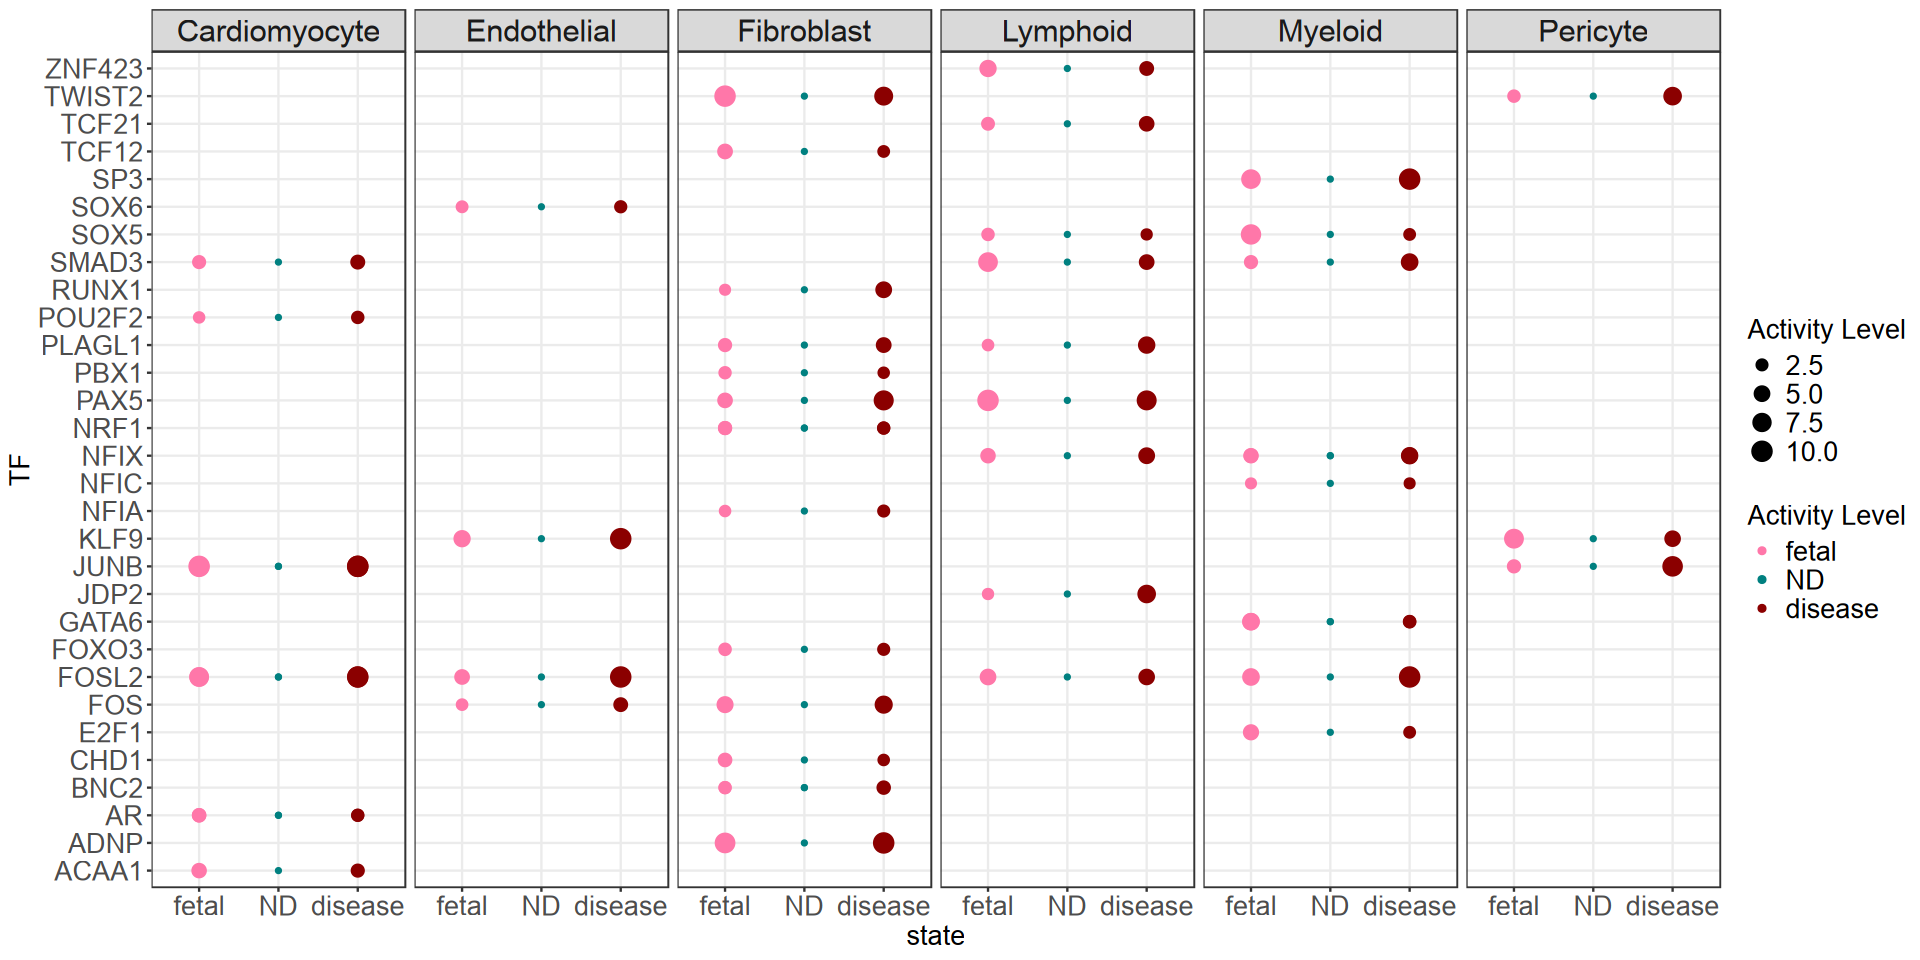

In [15]:
options(repr.plot.width = 16, repr.plot.height = 8)

# cap activity ratio at 10
updated_activity_pivot_df <- filtered_activity_pivot_df %>%
  mutate(activity_capped = pmin(activity, 10)) 

p1 <- ggplot(data = updated_activity_pivot_df, mapping = aes(x = state, y = TF, size = activity_capped, color = state)) + 
  geom_point() + 
  facet_wrap(~cell_type, ncol = 6) +  theme_bw() +
  theme(
    legend.text = element_text(size = 16), 
    legend.title = element_text(size = 16), 
    plot.title = element_text(size = 24, hjust = 0.5), 
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16),
    strip.text = element_text(size = 18)
  ) + 
  scale_size(range = c(1, 5)) +                    
  labs(
    color = "Activity Level",
    size = "Activity Level"
  ) + scale_color_manual(values = c("fetal" = "#FF77A9",
                                   "ND" = "#008080",
                                   "disease" = "#8B0000"))

ggsave(p1, filename = paste0(plots_dir, "fetalization_TFs.pdf"), width = 16, height = 8)

p1

### Visualize as bar plot

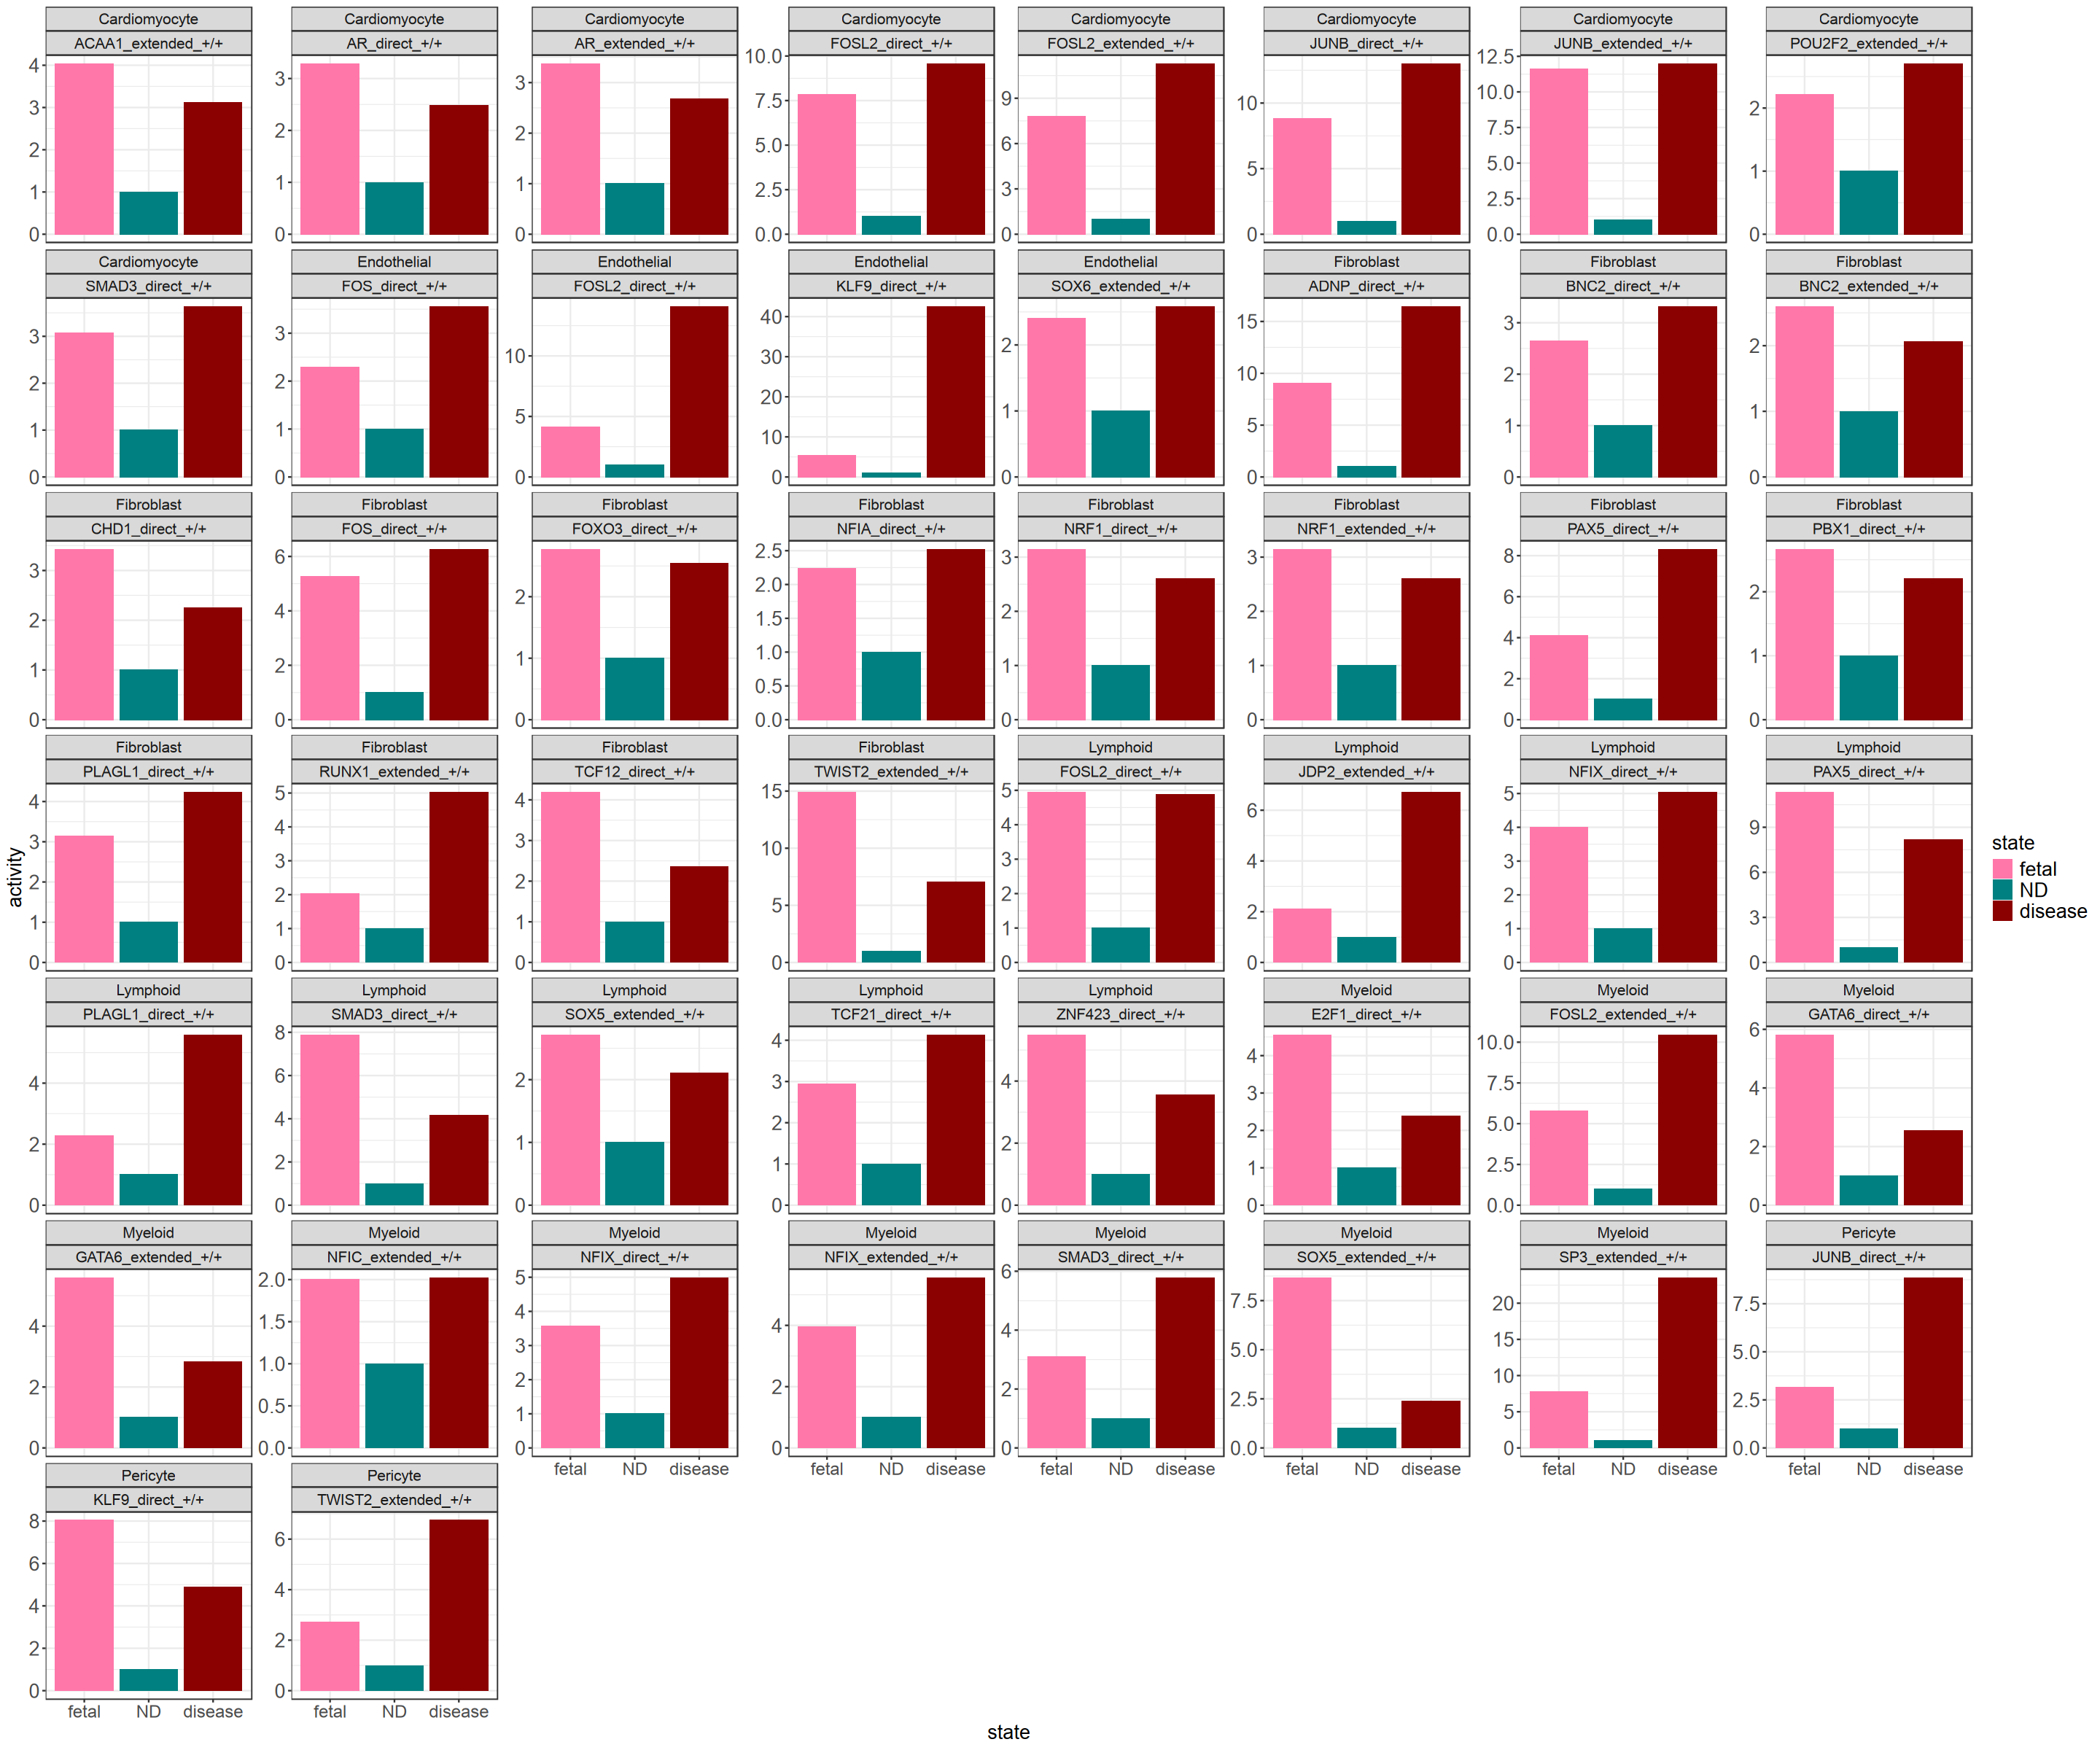

In [16]:
options(repr.plot.width = 24, repr.plot.height = 20)

ggplot(data = updated_activity_pivot_df, mapping = aes(x = state, y = activity, fill = state)) + 
geom_bar(stat="identity") + facet_wrap(~ cell_type + index, scale="free_y") + 
theme_bw() + theme(legend.text = element_text(size = 16), 
         legend.title = element_text(size = 16), 
         plot.title = element_text(size = 24, hjust = 0.5), 
         axis.title.x = element_text(size = 16),
         axis.title.y = element_text(size = 16),
         axis.text.x = element_text(size = 14),
         axis.text.y = element_text(size = 16),
         strip.text = element_text(size = 12)) + 
        scale_fill_manual(values = c("fetal" = "#FF77A9",
                                   "ND" = "#008080",
                                   "disease" = "#8B0000"))

In [17]:
write.csv(updated_activity_pivot_df, file = "04B_fetal_disease_regulons.csv")